In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

def run_ga(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval

    # Função de fitness (valor da função)
    def fitness(individual: float) -> float:
        return function(individual)

    # Seleção por torneio
    def tournament_selection(
        population: np.ndarray, fitness_values: np.ndarray, k: int = 3
    ) -> float:
        selected_indices = np.random.choice(len(population), size=k, replace=False)
        selected_fitness = fitness_values[selected_indices]
        winner_index = selected_indices[np.argmax(selected_fitness)]
        return population[winner_index]

    # Crossover (combinação de dois pais)
    def crossover(parent1: float, parent2: float) -> float:
        if np.random.rand() < crossover_rate:
            alpha = np.random.rand()  # Fator de mistura
            child = alpha * parent1 + (1 - alpha) * parent2
        else:
            child = parent1  # Sem crossover, retorna o primeiro pai
        return child

    # Mutação (perturbação aleatória)
    def mutate(individual: float) -> float:
        if np.random.rand() < mutation_rate:
            individual += np.random.uniform(-1, 1)  # Perturbação aleatória
            individual = np.clip(individual, LOW, HIGH)  # Garantir que está dentro dos limites
        return individual

    # Inicialização da população
    population: np.ndarray = np.random.uniform(LOW, HIGH, size=(pop_size,))

    # Evolução
    best_fitness_history: list[float] = []
    population_history: list[np.ndarray] = []  # Para armazenar as populações de cada geração

    for generation in range(gen_number):
        # Avaliar fitness da população
        fitness_values: np.ndarray = np.array([fitness(ind) for ind in population])

        # Guardar o histórico de fitness
        best_index: int = np.argmax(fitness_values)
        best_individual: float = population[best_index]
        best_fitness: float = fitness_values[best_index]
        best_fitness_history.append(best_fitness)

        # Armazenar a população atual para visualização
        population_history.append(population.copy())

        # Seleção, crossover e mutação
        new_population: list[float] = []

        # Elitismo: manter os melhores indivíduos
        tmp: np.ndarray = fitness_values.copy()
        for _ in range(elitism):
            best_index = np.argmax(tmp)
            best_individual = population[best_index]
            tmp[best_index] = -np.inf
            new_population.append(best_individual)

        # Gerar nova população
        while len(new_population) < pop_size:
            # Selecionar dois pais
            parent1: float = tournament_selection(population, fitness_values)
            parent2: float = tournament_selection(population, fitness_values)

            # Crossover
            child: float = crossover(parent1, parent2)

            # Mutação
            child = mutate(child)

            # Adicionar à nova população
            new_population.append(child)

        # Atualizar população
        population = np.array(new_population)

    # Resultado final
    best_index: int = np.argmax([fitness(ind) for ind in population])
    best_solution: float = population[best_index]
    best_fitness: float = fitness(best_solution)

    print(f"Melhor solução encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as populações em gráficos (3 gráficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals: np.ndarray = np.linspace(LOW, HIGH, 1000)
    y_vals: np.ndarray = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Função', color='blue')
        plt.scatter(
            population_history[generation], function(population_history[generation]), color='red', label='População'
        )
        plt.title(f'Geração {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolução do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Geração', color='green')
    plt.title('Evolução do Fitness')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

Melhor solução encontrada: x = 0.00785036851974899, f(x) = 0.9999897286506677


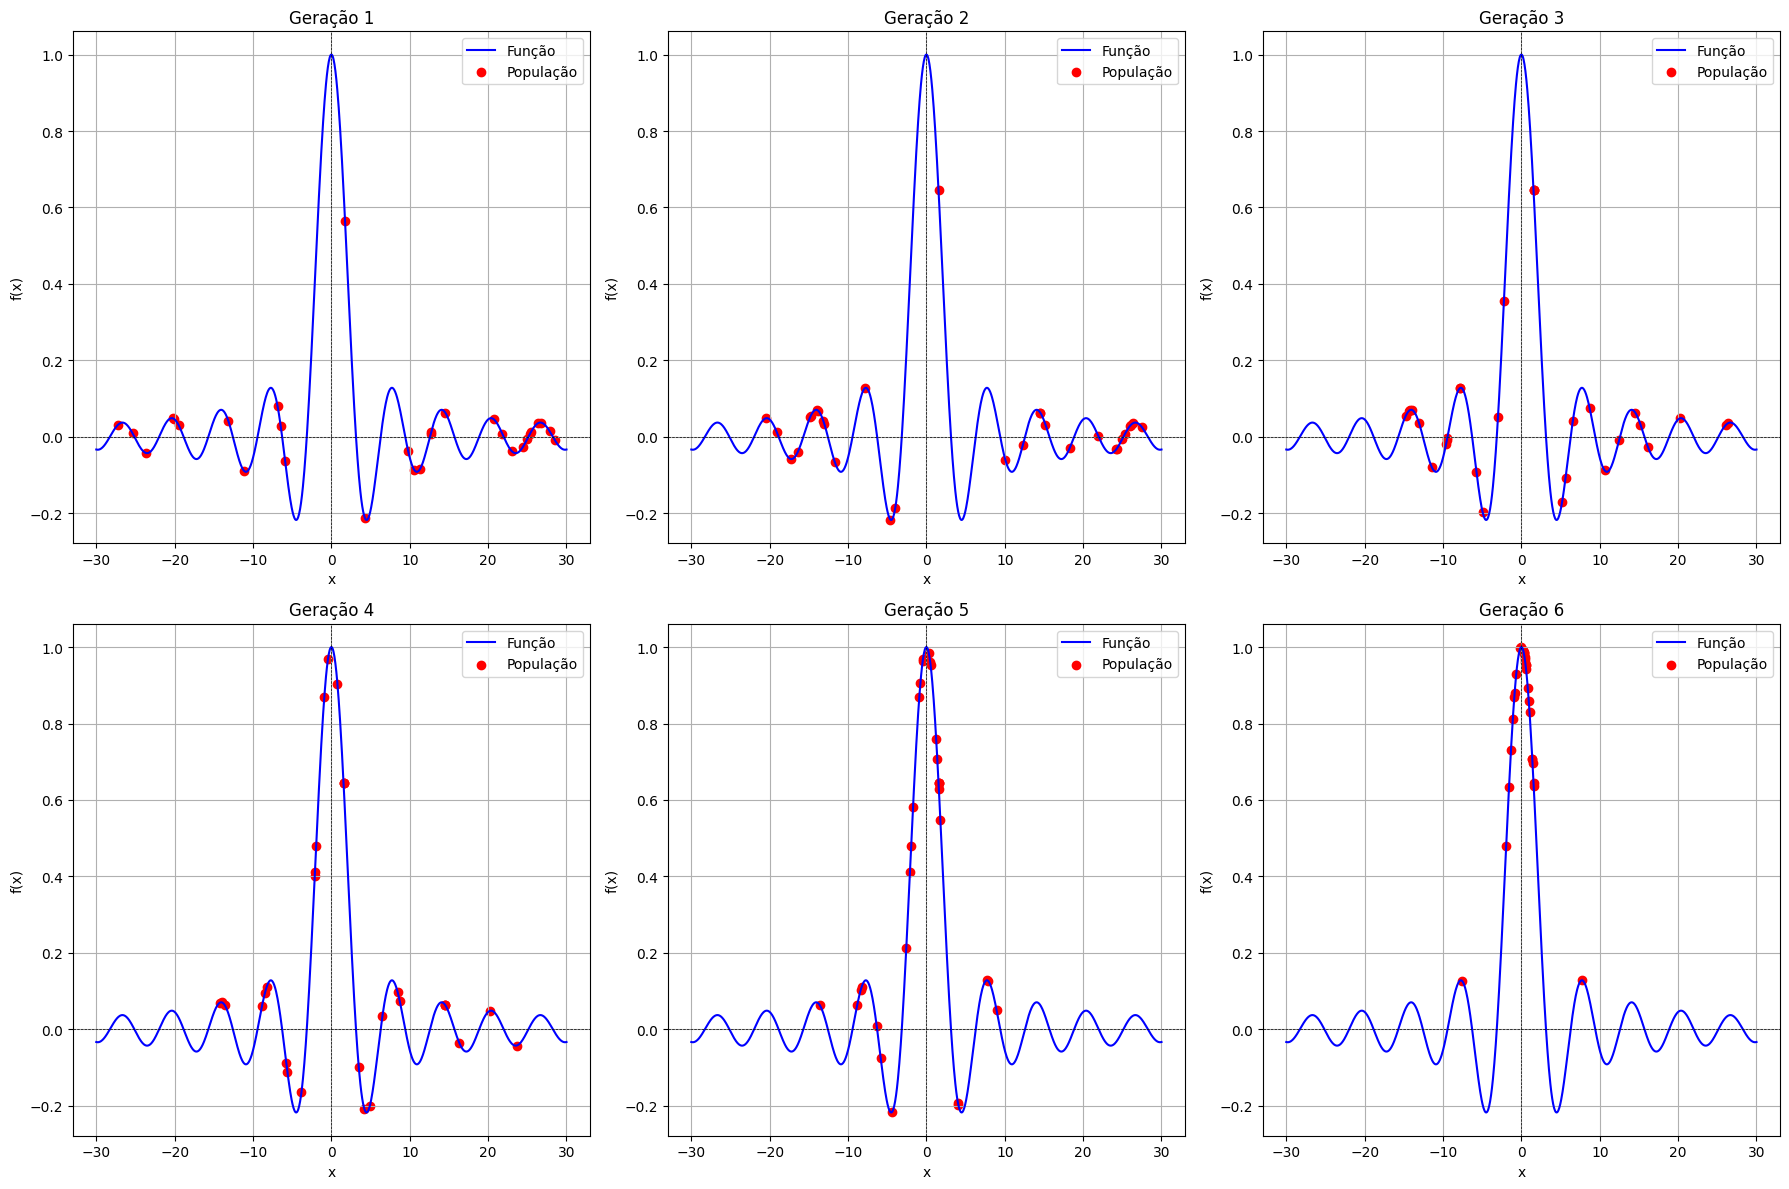

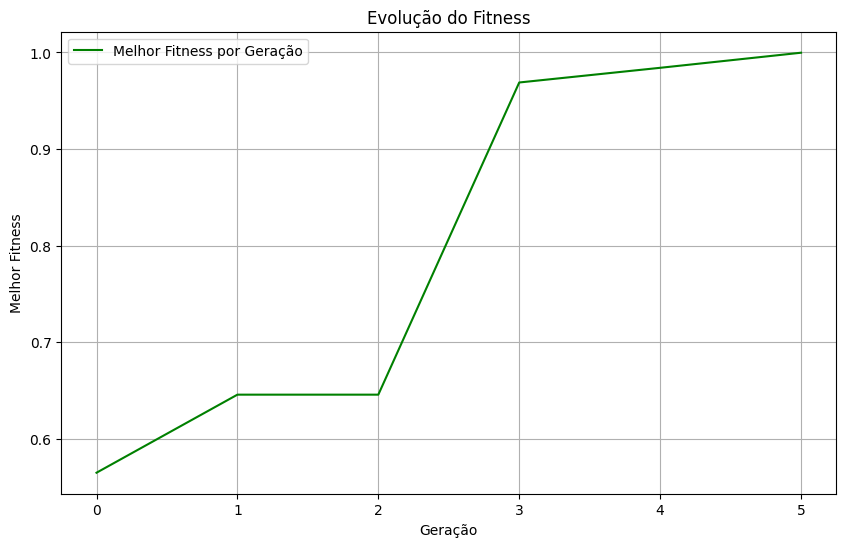

In [10]:
# Definição da função sinc
def f(x):
    return np.where(x == 0, 1.0, np.sin(x) / x)

run_ga(function=f, interval=[-30, 30])

Melhor solução encontrada: x = 10.070097909842492, f(x) = 1.045981491909247


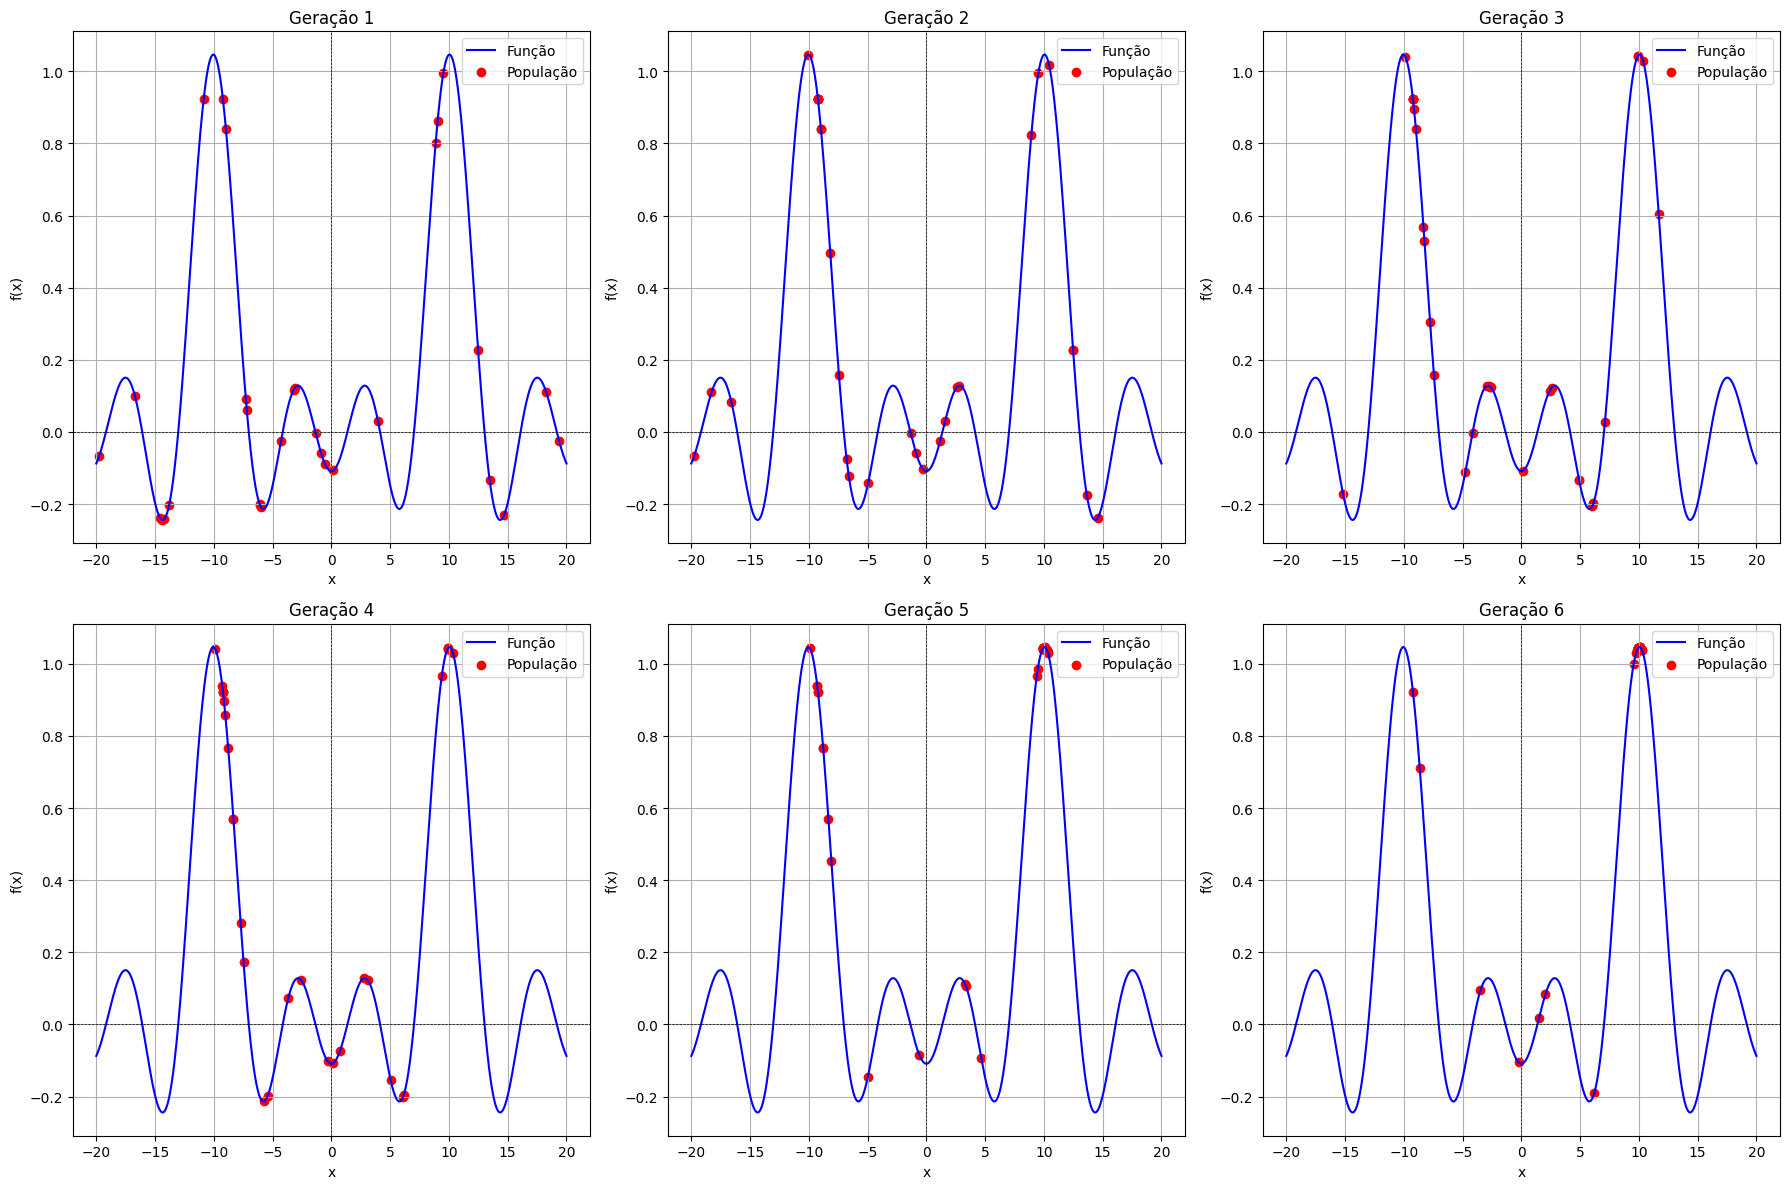

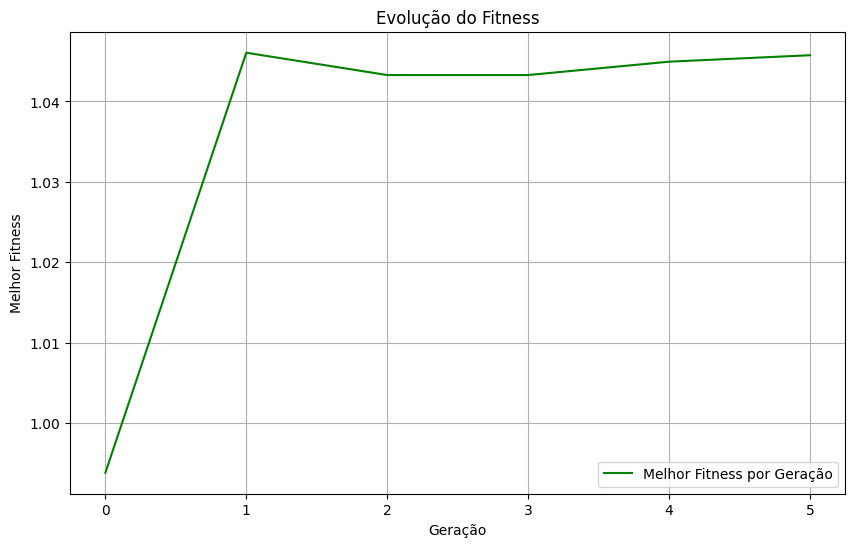

In [11]:
def f(x):
    c1 = 10
    c2 = -10
    a = x+c1
    b = x+c2
    return np.where(x == c1, 1.0, np.sin(a) / a) + np.where(x == c2, 1.0, np.sin(b) / b)

run_ga(function=f, interval=[-20, 20])

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from typing import Callable

def run_ga_deap(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval

    # Função de fitness (valor da função)
    def fitness(individual):
        return function(individual[0]),  # DEAP requer que a função de fitness retorne uma tupla

    # Definir tipos de indivíduos e populações
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar a função
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Criar população inicial
    def create_individual():
        return creator.Individual([random.uniform(LOW, HIGH)])

    # Criar a população
    population = [create_individual() for _ in range(pop_size)]

    # Ferramentas de seleção, crossover, mutação
    toolbox = base.Toolbox()
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=mutation_rate)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness)

    # Aplicar elitismo: se necessário, manter os melhores indivíduos
    if elitism > 0:
        elitism_tool = tools.HallOfFame(elitism)
        toolbox.register("halloffame", elitism_tool)

    # Histórico de fitness e populações para visualização
    best_fitness_history = []
    population_history = []

    # Evolução
    for generation in range(gen_number):
        # Avaliar a população
        fitness_values = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit

        # Guardar o histórico de fitness
        best_individual = tools.selBest(population, 1)[0]
        best_fitness = best_individual.fitness.values[0]
        best_fitness_history.append(best_fitness)

        # Armazenar a população para visualização
        population_history.append([ind[0] for ind in population])

        # Seleção, crossover, mutação
        offspring = toolbox.select(population, len(population) - elitism)

        # Elitismo: manter os melhores indivíduos
        if elitism > 0:
            elite = tools.selBest(population, elitism)
            offspring.extend(elite)

        # Crossover e mutação
        offspring_new = []
        for i in range(0, len(offspring) - 1, 2):
            parent1, parent2 = offspring[i], offspring[i + 1]

            # Crossover
            if random.random() < crossover_rate:
                toolbox.mate(parent1, parent2)
                del parent1.fitness.values
                del parent2.fitness.values

            # Mutação
            if random.random() < mutation_rate:
                toolbox.mutate(parent1)
                del parent1.fitness.values
            if random.random() < mutation_rate:
                toolbox.mutate(parent2)
                del parent2.fitness.values

            offspring_new.extend([parent1, parent2])

        # Atualizar a população
        population[:] = offspring_new

        # Atualizar o hall of fame (se usado)
        if elitism > 0:
            toolbox.halloffame.update(population)

    # Resultado final
    best_individual = tools.selBest(population, 1)[0]
    best_solution = best_individual[0]
    best_fitness = best_individual.fitness.values

    print(f"Melhor solução encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as populações em gráficos (3 gráficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals = np.linspace(LOW, HIGH, 1000)
    y_vals = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Função', color='blue')
        plt.scatter(
            population_history[generation], function(np.array(population_history[generation])), color='red', label='População'
        )
        plt.title(f'Geração {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolução do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Geração', color='green')
    plt.title('Evolução do Fitness')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()


Melhor solução encontrada: x = -4.534734700001292, f(x) = ()


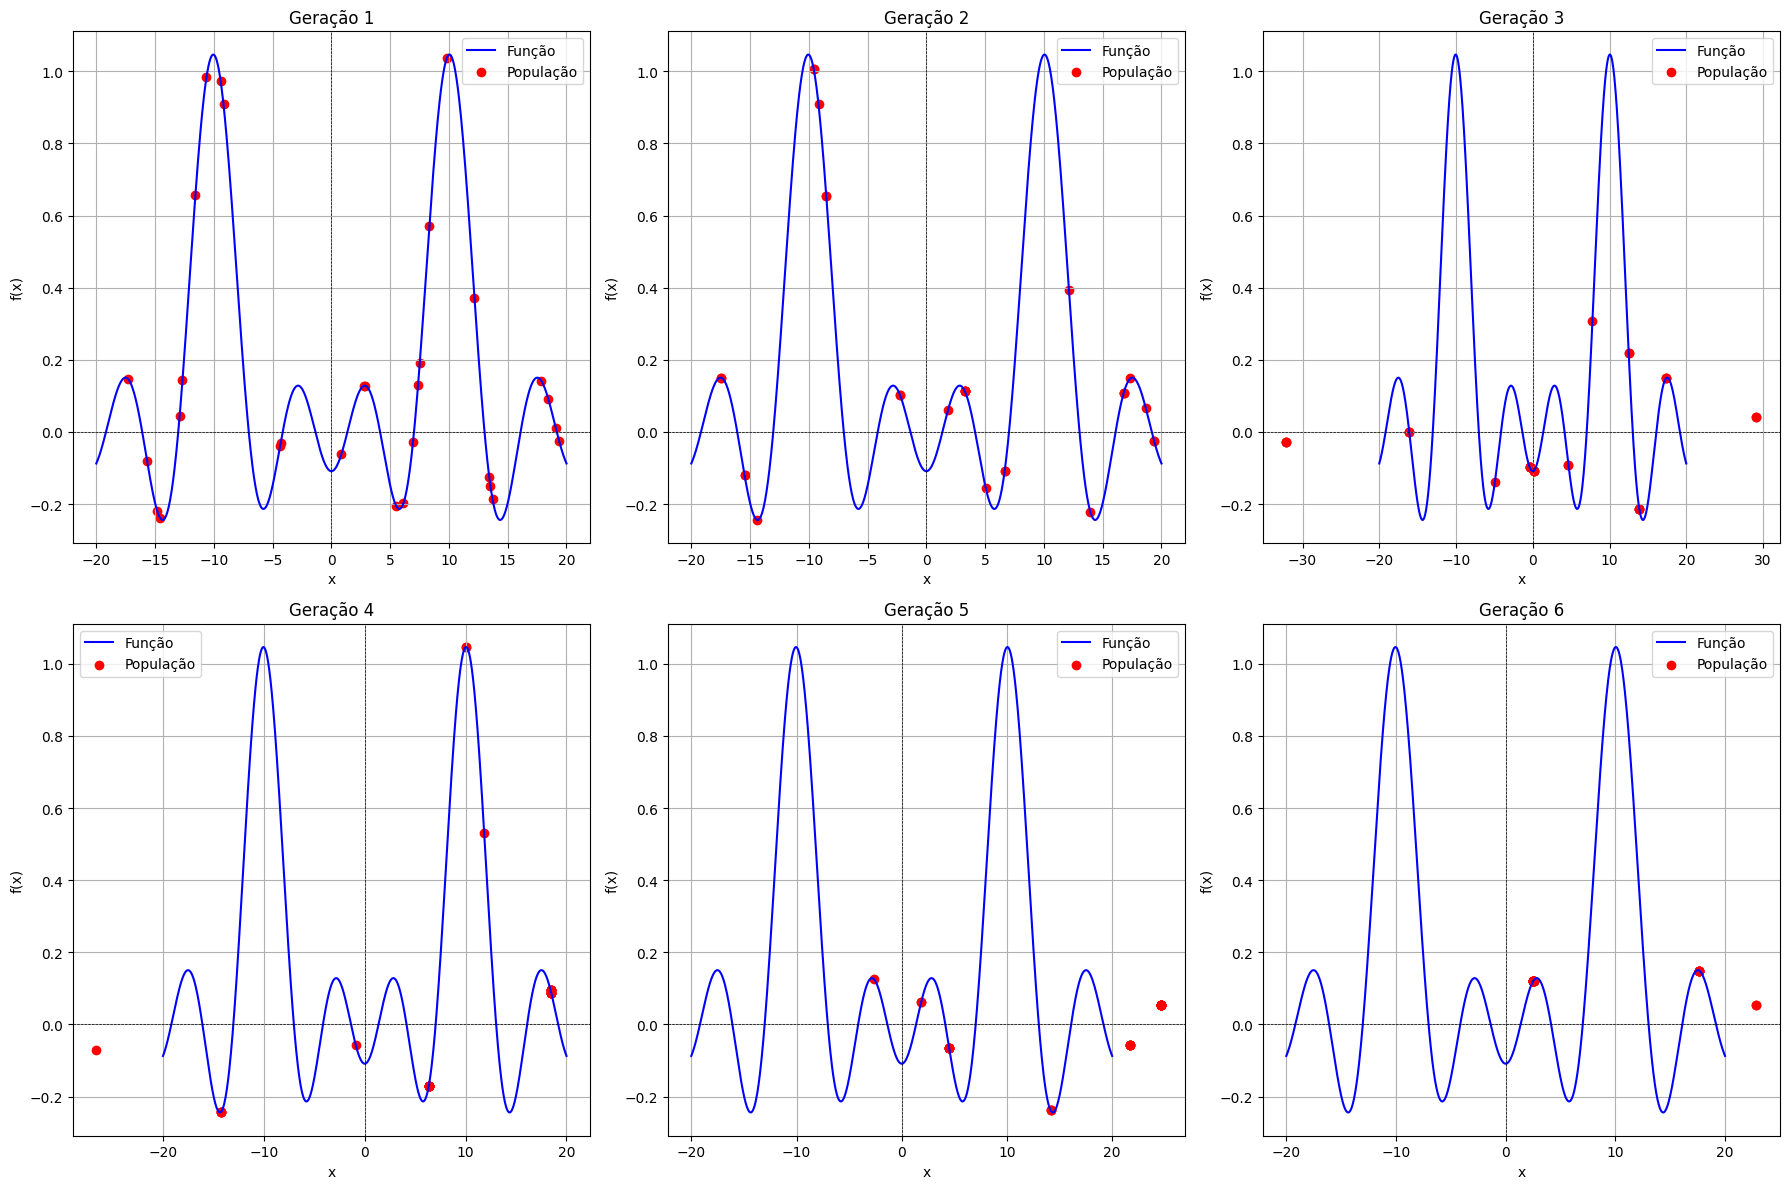

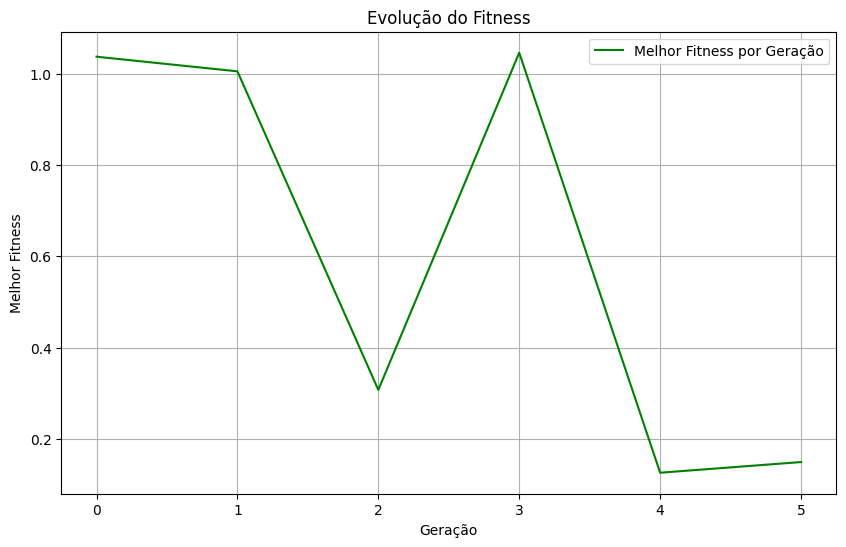

In [15]:
run_ga_deap(function=f, interval=[-20, 20])